In [1]:
import pandas as pd
pd.set_option("display.height", 10)
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_colwidth", 1000)
pd.set_option("display.width", 2000)

height has been deprecated.



In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sample = pd.read_csv('./sample_with_header.csv')

In [77]:
sample

,SichterGruppe,SichterName,Host,kind,Datetime,Content,Url,Authorid,Tag,entryid,Id,TwistId,TopicId,TopicName,IsInitialEntry,IsPrivate
0,NaN,NaN,twitter.com,1,21.10.2016 23:18:00,HighTechno ! Ich will Claras WG mal so richtig zu #Elektro dancen sehen . https://t.co/oLKYDGHBGQ,https://twitter.com/Carina42008/status/789576493810737152#aid=1394595750,3796107.0,NaN,bc6c4c70-a00d-429d-8bde-4e7afa072a15,31796013,04b9f324-5cee-4dd3-8387-0ff934ec1472,551631,Alle,False,False
1,NaN,NaN,twitter.com,3,21.10.2016 23:18:00,"Yeah , der WG gefällt deine Musik . Hol dir auch superschnelles Internet ! https://t.co/0dPArCUv0b https://t.co/HHRZaAQnte http://pbs.twimg.com/amplify_video_thumb/0123456789001234567890/img/QEQntlwB_ifYH3Gv.jpg",https://twitter.com/telekomerleben/status/789576496071446528#aid=20459730,1060906.0,NaN,5a676fbd-f7c7-45b1-8744-3a7fd8ebc9e9,31795989,04b9f324-5cee-4dd3-8387-0ff934ec1472,551631,Alle,True,False
2,Sichter FB/TW,Hotspot,www.facebook.com,1,24.09.2016 14:57:02,"Muss ich mit Hotspot registrieren wlan to go auf meinem Handy zu gehen , weiß ich nicht , wie es zu tun ich bin Telekom Kunde",https://www.facebook.com/122768271103611/posts/1141448189235609#pid=122768271103611&uid=122768271103611_1141448189235609&aid=992943974115174&vid=2&wid=122768271103611,7707299.0,NaN,94e8d4f1-60c1-45e5-894a-c11a3ff7b655,30744441,0be928df-7378-421e-be6e-07269f1dac19,551631,Alle,True,False
3,NaN,NaN,www.facebook.com,3,24.09.2016 15:12:35,"Hallo Fiona . Wenn Sie für WLAN TO GO angemeldet sind , dann können Sie unsere HotSpots nutzen in dem Sie sich mit Ihrer T-Online E-Mail-Adresse und dem dazugehörigen Passwort ( das gleiche wie für das Kundencenter ) anmelden . Viele Grüße Christian We .",https://www.facebook.com/122768271103611/posts/1141448189235609#pid=122768271103611_1141448189235609&uid=1141448189235609_1141458792567882&cpid=&aid=122768271103611&vid=2&wid=122768271103611,254017.0,NaN,263da5f3-4f0c-4a3e-ac27-358eb033912f,30744872,0be928df-7378-421e-be6e-07269f1dac19,551631,Alle,False,False
4,NaN,NaN,www.facebook.com,4,24.09.2016 15:16:45,"ich bin nicht gemeldet , es ok ich vergesse es",https://www.facebook.com/122768271103611/posts/1141448189235609#pid=122768271103611_1141448189235609&uid=1141448189235609_1141461172567644&cpid=1141448189235609_1141458792567882&aid=992943974115174&vid=2&wid=122768271103611,7707299.0,NaN,51a8de05-48e4-4422-822f-50aba72fb5f5,30745002,0be928df-7378-421e-be6e-07269f1dac19,551631,Alle,False,False
5,Sichter FB/TW,Hotspot,www.facebook.com,4,24.09.2016 15:18:01,"Jetzt muss ich mal eins fragen . Ich kann doch nicht mit Wlan to go alle Hotspots der Telekom kostenfrei nutzen , oder ? Was ich weiss nur die Hotspots der teilnehmenden Partner / Telekomkunden der Fa . Fon",https://www.facebook.com/122768271103611/posts/1141448189235609#pid=122768271103611_1141448189235609&uid=1141448189235609_1141461895900905&cpid=&aid=1096037533756491&vid=2&wid=122768271103611,127469.0,NaN,a255ed96-818f-42b2-84f1-0c0c7e2581da,30745045,0be928df-7378-421e-be6e-07269f1dac19,551631,Alle,False,False
6,NaN,NaN,www.facebook.com,4,24.09.2016 15:18:01,"Jetzt muss ich mal eins fragen . Ich kann doch nicht mit Wlan to go alle Hotspots der Telekom kostenfrei nutzen , oder ? Was ich weiss nur die Hotspots der teilnehmenden Partner / Telekomkunden der Fa . Fon",https://www.facebook.com/122768271103611/posts/1141448189235609#pid=122768271103611_1141448189235609&uid=1141448189235609_1141461895900905&cpid=&aid=1096037533756491&vid=2&wid=122768271103611,127469.0,NaN,a255ed96-818f-42b2-84f1-0c0c7e2581da,30745045,0be928df-7378-421e-be6e-07269f1dac19,551631,Alle,False,False
7,NaN,NaN,www.facebook.com,4,24.09.2016 15:19:10,ich weis nicht wie es geht :(,https://www.facebook.com/122768271103611/posts/1141448189235609#pid=122768271103611_1141448189235609&uid=1141448189235609_1141462655900829&cpid=1141448189235609_1141458792567882&aid=992943974115174&vid=2&wid=122768271103611,7707299.0,NaN,53632505-a61d-423e-bfc2-9f2047ad75b1,30745129,0be928df-7378-421e-be6e-

In [4]:
sample.query('kind==1 and SichterName').Content

2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Muss ich mit Hotspot registrieren wlan to go auf meinem Handy zu gehen , weiß ich nicht , wie es zu tun ich bin Telekom

In [5]:
pd.unique(sample.SichterName)

array([nan, 'Hotspot', 'Festnetz', 'Mobilfunk', 'GK', 'MMS', 'A-Team',
       'Mobile'], dtype=object)

In [6]:
import spacy

In [7]:
nlp = spacy.load('de')

In [8]:
sent = nlp('Ich heiße Oguz.')

In [9]:
for word in sent:
    print(word.pos_)

PRON
VERB
PROPN
PUNCT


In [82]:
documents = [] # Content
labels = [] # SichterName
tags = [] # Tag

for (idx, row) in sample.query('kind==1 and SichterName and Tag!="abgelegt durch Sichter" and Tag!="#Apfel"').iterrows():
    labels.append(row.SichterName)
    documents.append(nlp(row.Content))
    tags.append(row.Tag)

print(len(documents))

22


In [83]:
prios = np.array(tags)
prios = np.array(prios == 'Prio-Fall', dtype=int)
prios

In [86]:
labels[0], documents[0], prios[0]

('Hotspot',
 Muss ich mit Hotspot registrieren wlan to go auf meinem Handy zu gehen , weiß ich nicht , wie es zu tun ich bin Telekom Kunde,
 0)

In [16]:
from collections import Counter
# create lemma lists filter punctuation and numbers
# from spacy
lemmas = [word.lemma_ for words in documents for word in words if word.pos_ not in ['PUNCT','NUM']]
counts = Counter(lemmas)

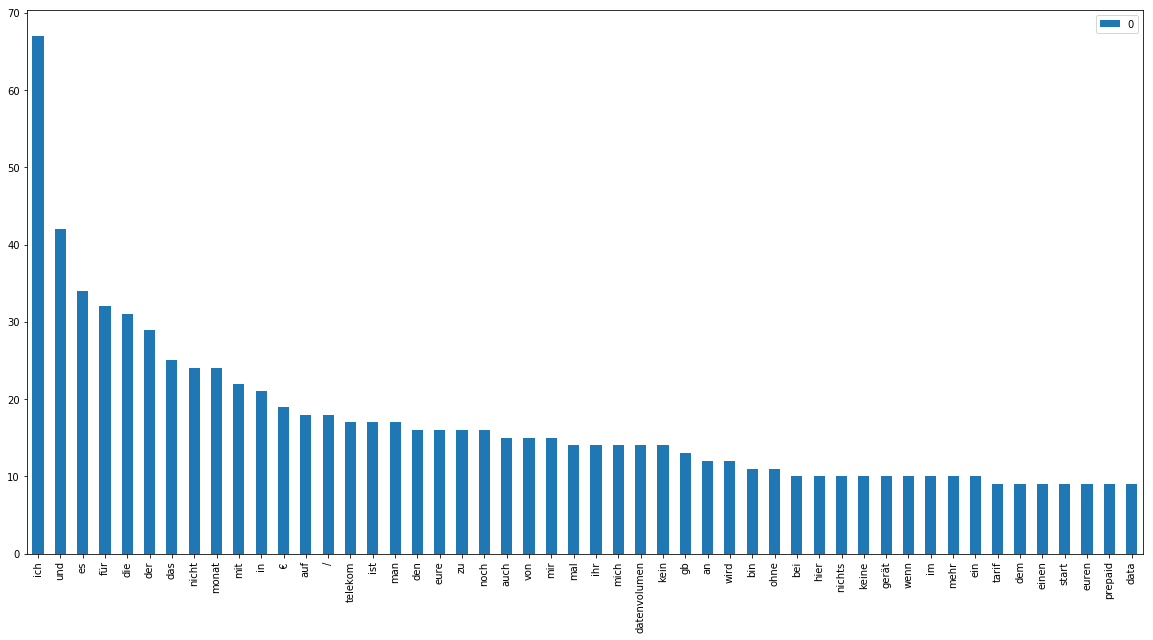

In [18]:
lemma_df = pd.DataFrame.from_dict(counts, orient='index')
lemma_df.sort_values(by=0,ascending=False).head(50).plot(kind='bar', figsize=(20,10))

In [24]:
with open('./stopwords-de.txt') as f:
    stopwords = f.read().split('\n')

In [ ]:
# TODO: use stopwords to filter lemmas
# TODO: try different sets of stopwords (e.g. with or without kein, nicht)

In [89]:
X = np.array([np.mean([word.vector for word in row], axis=0) for row in documents])

In [90]:
Y = np.array(prioss,dtype=int)

In [91]:
X_train = X[:14]
X_test = X[14:]
Y_train = Y[:14]
Y_test = Y[14:]

In [92]:
Y_train

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [101]:
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight
gnb = GaussianNB()

weights = class_weight.compute_sample_weight('balanced', [0,1], Y_train)
weightss = []
for y in Y_train:
    weightss.append(weights[y])

y_pred = gnb.fit(X_train, Y_train, sample_weight=weightss).predict(X_test)

In [102]:
weightss

[0.5384615384615384,
 0.5384615384615384,
 7.0,
 0.5384615384615384,
 0.5384615384615384,
 0.5384615384615384,
 0.5384615384615384,
 0.5384615384615384,
 0.5384615384615384,
 0.5384615384615384,
 0.5384615384615384,
 0.5384615384615384,
 0.5384615384615384,
 0.5384615384615384]

In [103]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0])